# Repetition Code (Bit Flip)

We start with some preliminary packages and functions, nothing fancy.

In [59]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister
# Loading your IBM Q account(s)
#IBMQ.save_account('1111fdc84fb52cd6a6ae57fc29ae3166444b265152e05e051e3c5051a3891f9c278fc82caee116aac2e46be7825435a4851613049483e87e281ff4cb6ee13158')


In [60]:
#secondary modules
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

$ZZ$ stabilizer function

In [61]:
### ZZ (bit-flip) stabilizer 
def ZZ(circ, qubit_1, qubit_2, ancilla_qubit, classical_bit):
    #Z1Z2 Measurements
    circ.cx(qubit_1, ancilla_qubit)
    circ.cx(qubit_2, ancilla_qubit)
    circ.measure(ancilla_qubit, classical_bit)
    return

## Definition of the initial quantum circuits

We consider a repetiotion code which involves an odd number of qubits, $N$, to which we add a single ancilla qubit in order to perform stabilizing mesurements and classical bits to keep the results.
The main qubit ($q_0$ in the circuit) is the one we consider in our calculations, a.k.a the __logical__ qubit.
In order to simulate some errors a bit-flip ($X$) gate can be added with certain distribution (chosen by us, but always smaller than $0.5$) on every qubit.
Our reprtiotion code is able to detect and thus correct (using software) up to $(N-1)/2$ bit-flips.

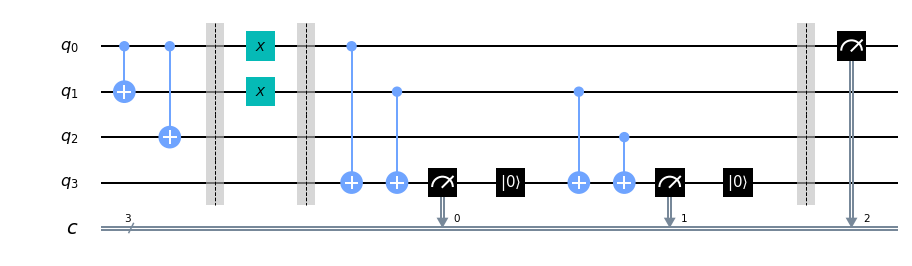

In [67]:
###Variable circuit coefficients
num_qubits = 3
p_flip = 0.4

###Other coefficients
num_clbits = num_qubits
ancilla_qubit = num_qubits #ancilla qubit number

#Here we define the quantum circuits with physical qubits, 1 syndrome qubit and cllasical qubits.
circ = QuantumCircuit(num_qubits+1 , num_clbits)

#Repetition Code
for i in range (1,num_qubits):
    circ.cx(0, i)
circ.barrier()

#Induced Error
for i in range(num_qubits-1):
    if random.uniform(0, 1)<p_flip:
        circ.x(i)
    

circ.barrier()

#Bit-Flip Stabilizers
for i in range(num_qubits-1):
    ZZ(circ, i, i+1, ancilla_qubit, i)
    circ.reset(ancilla_qubit)
circ.barrier()    

#Error Correction

#Main Qubit Measurement on the last Classical bit
circ.measure(0,num_clbits-1)

circ.draw(output="mpl")

## Simulating on the quantum simulator

C:\Users\User\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


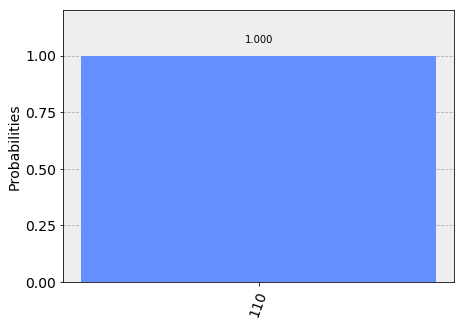

In [68]:
#IBMQ.save_account('1111fdc84fb52cd6a6ae57fc29ae3166444b265152e05e051e3c5051a3891f9c278fc82caee116aac2e46be7825435a4851613049483e87e281ff4cb6ee13158', overwrite=True)
IBMQ.load_account() # Load account from disk
from qiskit import visualization
%matplotlib inline

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')
backend_sim = Aer.get_backend('qasm_simulator')
result = execute(circ, backend_sim).result()
counts  = result.get_counts(circ)


visualization.plot_histogram(counts)

## Software Error Correction

We assume that there is no error in the $ZZ$ measurement process or with the ancilla qubit.
Any syndrom string corresponds to two possible qubit strings ($2^N / 2^{(N-1)}$, where $N-1$ is the number of stabilizing measurements), and we pick the more probable one, the one where the number of bit-flips is smaller than $N/2$.

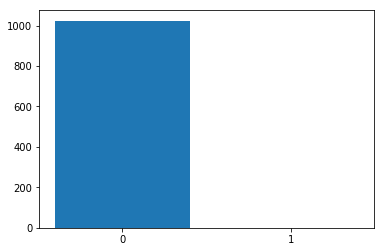

In [64]:
zero_counts = 0
one_counts = 0
for  count_index, count in enumerate(counts):
    logical_qubit_value = int(count[0])
    
    ###Check whether to flip the first (main) qubit or not
    flipped = True #Assume the first qubit is flipped
    num_qubits_flipped = 1
    for qubit_index in range(1,num_clbits):
        if count[-qubit_index] == '1': #Qubits are in different states
            print('qubits ' + str(qubit_index-1) + ' and ' + str(qubit_index) + ' are different!')
            flipped = not flipped #current qubit is different than the previous
            if flipped:
                num_qubits_flipped += 1
        else:
            if flipped:
                num_qubits_flipped += 1      
    if num_qubits_flipped < (num_qubits / 2): #Number of flipped qubits assuming the first (main) one is flipped  
        logical_qubit_value = (logical_qubit_value + 1) % 2 #Logical Qubit Bit Flip
        
###Count how many times in total 0 was measured (correction worked) and how many times 1 (error)
    if logical_qubit_value == 0:
        zero_counts += counts[count]
    else:
        one_counts += counts[count]

plt.bar([0, 1], [zero_counts,one_counts])
plt.xticks(np.arange(2),('0', '1'))
plt.show()

Since we consider all gates to be errors counts in which $0$ was measured are considered a success, while a $1$ measurement is a failure.

## Error probability

An error (i.e. measure a flipped main qubit even after the software correction) happens where more than half of the qubits have flipped in the process and its probability depends on the probability to have any qubit flipped, which we denote $p_{flip}$, as follows:
$$p_{error} = \sum _{n=(N+1)/2}^{N} \binom {N}{n} p_{flip}^{n} (1- p_{flip})^{N-n}$$
This dependence is shown in the following code/graph:

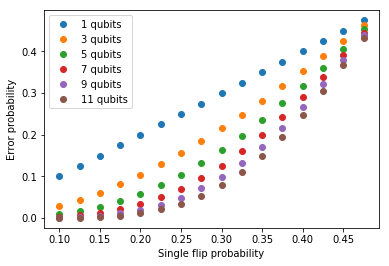

In [65]:
def p_error(p_flip, num_qubits):
    p_error = 0
    for n in range (int((num_qubits+1)/2), num_qubits+1):
        p_error += scipy.special.binom(num_qubits, n) * p_flip**n * (1-p_flip)**(num_qubits-n)
    return p_error

nums_qubits = np.arange(1,13,2)
# nums_qubits = np.arange(1,5,2)
ps_flip = np.arange(0.1, 0.5, 0.025)
prob_error = np.zeros((len(nums_qubits) ,len(ps_flip)), dtype = float)

for i,num_qubits in enumerate(nums_qubits):
    for j,p_flip in enumerate(ps_flip):
        prob_error[i,j] = p_error(p_flip, num_qubits)

for i in range(len(nums_qubits)):
    plt.plot(ps_flip, prob_error[i,:], 'o', label='%i qubits' %nums_qubits[i], )

plt.xlabel(r'Single flip probability')
plt.ylabel(r'Error probability')
plt.legend()
plt.show()

## Running the code on a real machine

This section does not work for the time being.

In [66]:
# Next, find the least-busy, but real, IBM device
from qiskit.providers.ibmq import least_busy
provider = IBMQ.get_provider(hub='ibm-q')
real_device = least_busy(provider.backends(simulator=False))
print(real_device)

#Or pick a specific device

# And run the circuit on that device
job = execute(circ, backend=real_device, shots=1024)
from qiskit.tools.monitor import job_monitor
job_monitor(job)
result = job.result()

from qiskit import visualization
%matplotlib inline

#backend = provider.get_backend('ibmq_qasm_simulator')
#result = execute(circuit, backend).result()
counts  = result.get_counts(circ) 

# Finally, plot a histogram of the results
visualization.plot_histogram(counts)

import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)


ibmq_essex
Job Status: job is queued (13)      

KeyboardInterrupt: 